## Implementation of Convolutional Neural Network

The objective here is to design Convolutional Neural Network for classification task on two datasets. We will first implement Convolutional Neural Network in Python and then study the effect of pooling, dropout, batch normalization and learning rate for a classifcation task. <br>
The two datasets are: <br>
(a) cifar10 <br>
(b) Bricklane <br>

Please note: <br>
-We will save each trained model weights and tensorboard logs in different folders. <br>
-Your system memory may overflow while running the code. In that case please reset memory for trained model(s) keeping printed logs and history of trained model. History of all trained models could be used to plot the trends. <br>
-For trends you shall also use tensorboard logs 

Let's first import the necessary libraries

In [1]:
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K
from keras.datasets import cifar10
import keras

from sklearn.model_selection import train_test_split
from IPython.display import display

import cv2 as cv
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#import seaborn as sns

import os
your_id = 17060015
np.random.seed(your_id)
import pickle as p

Using TensorFlow backend.


###### Hyperparameters

In [2]:
batch_size = 16
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
input_shape = (32,32,3)
images_dir = 'images/'

#####  Load dataset information
[_cifar10_](https://www.cs.toronto.edu/~kriz/cifar.html) dataset contains 10 classes including airplane, bird, cat etc. Dataset can be downloaded from [LINK](http://pjreddie.com/media/files/cifar.tgz) or [LINK2](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz). 
<br> _cifar10_ dataset is also available in keras but it is recommended to use the downloaded from above given link as ```cifar10.load_data()``` function downloads and loads complete data on RAM. 
<br> <br>
This [Github](https://github.com/EN10/CIFAR) link is also very helpful to load _cifar10_ dataset yourself.


In [6]:
def load_batch(fpath):
    with open(fpath, 'rb') as f:
        dict = p.load(f, encoding='bytes')
        
        d_decoded = {}
        for k, v in dict.items():
            d_decoded[k.decode('utf8')] = v
        dict = d_decoded
            
    images = np.array(dict['data'])
    labels = np.array(dict['labels'])
    
    images = images.reshape(images.shape[0], 3, 32, 32)
    
    return images, labels

def load_dataset():
    dirname = 'cifar-images'
    
    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8') #empty placeholder
    y_train = np.empty((num_train_samples,), dtype='uint8')           #empty placeholder
    
    for i in range(1, 6):
        fpath = os.path.join(dirname, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000: i * 10000, :, :, :], y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)
    
    y_train = np.reshape(y_train, (len(y_train), 1))                  #reshaping the vector

    fpath = os.path.join(dirname, 'test_batch')

    x_test, y_test = load_batch(fpath)
    y_test = np.reshape(y_test, (len(y_test), 1))                     #reshaping the vector

    if (K.image_data_format() == 'channels_last'):
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)

In [8]:
(x_train, y_train), (x_test, y_test) = load_dataset()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=your_id)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

x_train shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples


We can use the following method as well

In [ ]:
#import glob
#paths = glob.glob(dir + '/*airplane.png')
#airplane_image = [cv.imread(x) for x in paths]

In [ ]:
#Method 2

#dir2 = 'dataset2'
#class_names = os.listdir(dir2)
#print('class_names', class_names)
#paths1 = os.listdir(os.path.join(dir2, class_names[0]))
#label1 = np.ones(len(paths1)) + 0
#print (label1)
#paths2 = os.listdir(os.path.join)(dir2, class_names[1])
#label2 = np.ones(len(paths1)) + 1

##### Preprocessing
Preprocessing of data such as normalization, mean shift, make the learning task simple for network and can accelerate the training process. 

For the images, pixel values vary from 0 to 255. To shift the values between (0,1) range, we divide input image by 255. Now, we retrain the model designed above with scratch with preprocessed data. 

In [10]:
def preprocessing_norm (images):
    return [x/255 for x in images]

For the images, pixel values vary from 0 to 255. Compute the channel wise mean and standard daviation (std) for the whole dataset, subtract channel-wise mean and divide by channel-wise std. This will shift the mean to zero and varation to 1.

In [11]:
def preprocessing_meanShift (images):
    
    processed_images = (images - np.mean(images, axis=0)) / np.std(images, axis=0)
    
    return processed_images

#####  Batch Generator
For the training, we load complete data (inputs, outputs) into RAM and then provide it to "model.fit" function. However, when dataset is very large in size we cannot load complete data on RAM. We then, load the data batchwise. To do this, we write a generator function that will load a batch of data (images and output), preprocess images and return a tuple as (inputs, outputs) on every step. 

In [12]:
def data_generator(images_paths,label_file, batch_size = 64, preprocessing = None):
    
    while True:
        batch_start = 0
        batch_end = len(label_file)
        
        while ((batch_start+batch_size)<=batch_end):
          
            batch_images = images_paths[batch_start:batch_start+batch_size]  #obtain images of the batch
            batch_labels = label_file[batch_start:batch_start+batch_size]    # corresponding labels

            if (preprocessing is None):             
                pass
            elif (preprocessing == 'method1'): 
                batch_images = preprocessing_norm(batch_images)     # so method1 will call normalization
            else:
                batch_images = preprocessing_meanShift(batch_images) #any other name will call mean-shift
            
            batch_x = np.array(batch_images) #convert it to to a numpy array
            batch_y = np.array(batch_labels) #convert it to to a numpy array
            batch_start += batch_size        # call for the next batch
            yield( batch_x, batch_y )      #when this gives, the next batch will start from above calculation
          

##### Design CNN model

In [13]:
input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model = Model(inputs=input_im, outputs=output_class)

##### Compile model and plot

In [14]:
model_name = '17060015_model1'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)        # so, default learning rate of Adam is : 0.001
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 44)                34540     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                450       
Total params: 36,382
Trainable params: 36,382
Non-trainable params: 0
_________________________________________________________________


##### Training model
In order to train the model, instead of "model.fit" function, we will use "model.fit_generator" function for training. For details check out [keras documentation](https://keras.io/models/sequential/)

In [15]:
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

In [16]:
epochs = 20 #not sure how many !
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr] #storing all the callabacks for Tensorboard

###### Training model without any pre-processing
Train model without using any pre-processing scheme

In this section: we will first train our model without any pre-processing strategy and observe the results
The results are stored as: 17060015_model1

In [18]:
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
test_gen = data_generator(x_test, y_test, batch_size)

In [19]:
x,y= val_gen.__next__()

In [20]:
hist1 = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

# save model

Epoch 1/20
2500/2500 [==============================] - 15s 6ms/step - loss: 2.0412 - acc: 0.2957 - val_loss: 1.5982 - val_acc: 0.4095

Epoch 00001: val_loss improved from inf to 1.59820, saving model to 17060015_model1/17060015_model1-01-1.60.h5
Epoch 2/20
2500/2500 [==============================] - 17s 7ms/step - loss: 1.5311 - acc: 0.4436 - val_loss: 1.4730 - val_acc: 0.4684

Epoch 00002: val_loss improved from 1.59820 to 1.47304, saving model to 17060015_model1/17060015_model1-02-1.47.h5
Epoch 3/20
2500/2500 [==============================] - 13s 5ms/step - loss: 1.4039 - acc: 0.4957 - val_loss: 1.4310 - val_acc: 0.4947

Epoch 00003: val_loss improved from 1.47304 to 1.43098, saving model to 17060015_model1/17060015_model1-03-1.43.h5
Epoch 4/20
2500/2500 [==============================] - 14s 6ms/step - loss: 1.3318 - acc: 0.5237 - val_loss: 1.4344 - val_acc: 0.5026

Epoch 00004: val_loss did not improve from 1.43098
Epoch 5/20
2500/2500 [==============================] - 14s 6ms/

###### Train model by using Preprocessing
Train model by using data preprocessing i.e normalization or mean shift. 

Now we will explore how learning gets affected by the use of preprocessing techniques: <br>
- Normalization
- Mean shift

In [22]:
model = None

input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model = Model(inputs=input_im, outputs=output_class)

model_name = '17060015_model152_norm'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001) #with the default learning rate, because we wish to compare !
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

# save model

epochs = 20 # use the same number of epochs when comparing with the "without preprocessing method"
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = "method1") #normalization 
val_gen = data_generator(x_val, y_val, batch_size)
test_gen = data_generator(x_test, y_test, batch_size)

hist2_norm = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 44)                34540     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                450       
Total params: 36,382
Trainable params: 36,382
Non-trainable params: 0
_________________________________________________________________
Epoch 

In [23]:
model = None

input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model = Model(inputs=input_im, outputs=output_class)

model_name = '17060015_model152_meanshift'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001) #with the default learning rate, because we wish to compare !
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

# save model

epochs = 20 # use the same number of epochs when comparing with the "without preprocessing method"
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = "mean_shift") #mean shift 
val_gen = data_generator(x_val, y_val, batch_size)
test_gen = data_generator(x_test, y_test, batch_size)

hist2_mean = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 44)                34540     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                450       
Total params: 36,382
Trainable params: 36,382
Non-trainable params: 0
_________________________________________________________________
Epoch 

##### Pooling
Now, we modify the model by adding pooling layer(s). Pooling could be "Average pooling" or "Max pooling". The size and stride for pooling can be of our choice. 
<br> 
We modify the network by introducing pooling layer and train the model using __fit_generator__ function. 

In [24]:
model = None

input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #(w, h)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flat = Flatten()(pool2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model = Model(inputs=input_im, outputs=output_class)

model_name = '17060015_model21'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

# save model

epochs = 20 # let it be same !
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = "mean_shift")
val_gen = data_generator(x_val, y_val, batch_size)
test_gen = data_generator(x_test, y_test, batch_size)
hist3 = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 16)          1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 44)                748       
__________

##### Dropout
We modify the network by introducing dropout layer and train the model using __fit_generator__ function. 

In [25]:
model = None

input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
drop1 = Dropout(rate=0.20)(conv2) #dropout layer
flat = Flatten()(drop1)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model = Model(inputs=input_im, outputs=output_class)

model_name = '17060015_model31'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

# save model


epochs = 20
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = "mean_shift")
val_gen = data_generator(x_val, y_val, batch_size)
test_gen = data_generator(x_test, y_test, batch_size)


hist4 = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 16)          1168      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 44)                34540     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                450       
Total para

##### Batch Normalization
Let's modify the network by introducing batch normalization layer and train the model. 

In [26]:
model = None


model_name = '17060015_model41'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

# ====================================================   
input_im = Input(shape=(input_shape), name='input_im')
# Hidden Layers
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
norm1 = BatchNormalization()(conv2) #batch normalization
flat = Flatten()(norm1)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)
model = Model(inputs=input_im, outputs=output_class)
# ====================================================
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

hist41 = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

# save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 16)          1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 44)                34540     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                450       
Total para

##### Comparision of all model

We will plot the loss and accuracy for all models and __discuss__ which model has better performance and why?

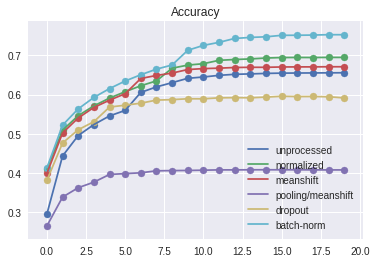

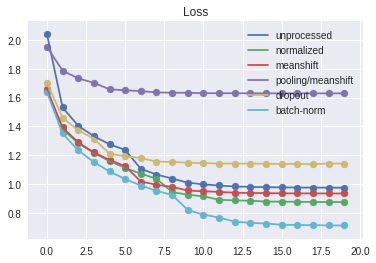

In [33]:
# plot Accuracy of all models
plt.clf() 
x_axis = list(range(epochs))
plt.plot(x_axis, hist1.history['acc'], label='unprocessed')
plt.scatter(x_axis, hist1.history['acc'])
plt.plot(x_axis, hist2_norm.history['acc'], label='normalized')
plt.scatter(x_axis, hist2_norm.history['acc'])
plt.plot(x_axis, hist2_mean.history['acc'], label='meanshift')
plt.scatter(x_axis, hist2_mean.history['acc'])
plt.plot(x_axis, hist3.history['acc'], label='pooling/meanshift')
plt.scatter(x_axis, hist3.history['acc'])
plt.plot(x_axis, hist4.history['acc'], label='dropout')
plt.scatter(x_axis, hist4.history['acc'])
plt.plot(x_axis, hist41.history['acc'], label='batch-norm')
plt.scatter(x_axis, hist41.history['acc'])
plt.legend()
plt.title('Accuracy')
plt.show()


# plot loss of all models
plt.clf() 
x_axis = list(range(epochs))
plt.plot(x_axis, hist1.history['loss'], label='unprocessed')
plt.scatter(x_axis, hist1.history['loss'])
plt.plot(x_axis, hist2_norm.history['loss'], label='normalized')
plt.scatter(x_axis, hist2_norm.history['loss'])
plt.plot(x_axis, hist2_mean.history['loss'], label='meanshift')
plt.scatter(x_axis, hist2_mean.history['loss'])
plt.plot(x_axis, hist3.history['loss'], label='pooling/meanshift')
plt.scatter(x_axis, hist3.history['loss'])
plt.plot(x_axis, hist4.history['loss'], label='dropout')
plt.scatter(x_axis, hist4.history['loss'])
plt.plot(x_axis, hist41.history['loss'], label='batch-norm')
plt.scatter(x_axis, hist41.history['loss'])
plt.legend()
plt.title('Loss')
plt.show()

###### Observations:
In terms of accuracy: <br>
-Model with the batch-normalized layer has the highest performance followed by model having preprocessing with
normalization of the images in the dataset. <br>
-Adding the dropout layer has reduced the accuracy  of the model. <br>
-Pooling degrades the performance significantly. <br>

Similar observations can be made about the models by analyzing the loss curves above!

###### Tensorboard 

You can run TensorBoard using the following command
```tensorboard --logdir=path/to/log-directory
```
Now for logs of all above trained models, take snapshot of the _loss_ and _accuracy_ plots and save in the directory where this notebook is. To show that saved plot here in notebook use following command in _markdown_ cell. 
<br> __![](path_to_image)__

- Tensorboard plot of accuracies:
!['loss'](loss.png)

- Tensorboard plot of accuracies:
!['Accuracy](acc.png)


##### Visualize Activations
We visualize the activations (outputs) of both the convolution layers of a model.

Convolution 1 shape: (1, 15, 15, 8)


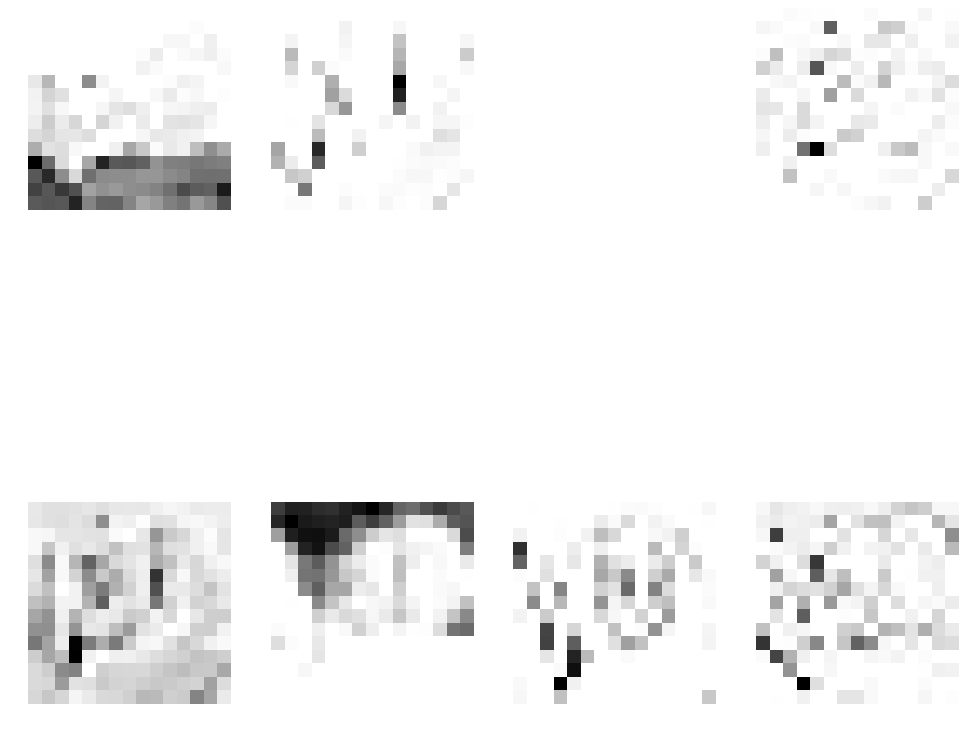

In [34]:
## ADD you code here
new_model = Model(inputs=input_im, 
                  outputs=model.get_layer('conv2d_11').output) #the convolution layer from above !
con1_activations = new_model.predict(x_test[0,:,:].reshape((1,32,32,3)))
print('Convolution 1 shape:',con1_activations.shape)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,15), dpi=80)

for i,ax in enumerate(axes.flatten()):
    ax.imshow(con1_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

#####  Effect of learning rate

We take the best selected model above and change its learning rate to: 
- 6.1.1 any value between 5 and 1.
- 6.1.2 learning rate = any value between 0.6 and  0.1 
- 6.1.3 learning rate = 0.00001

and train these three models to compare the effect learning rate.

Convolution 2 shape: (1, 7, 7, 16)


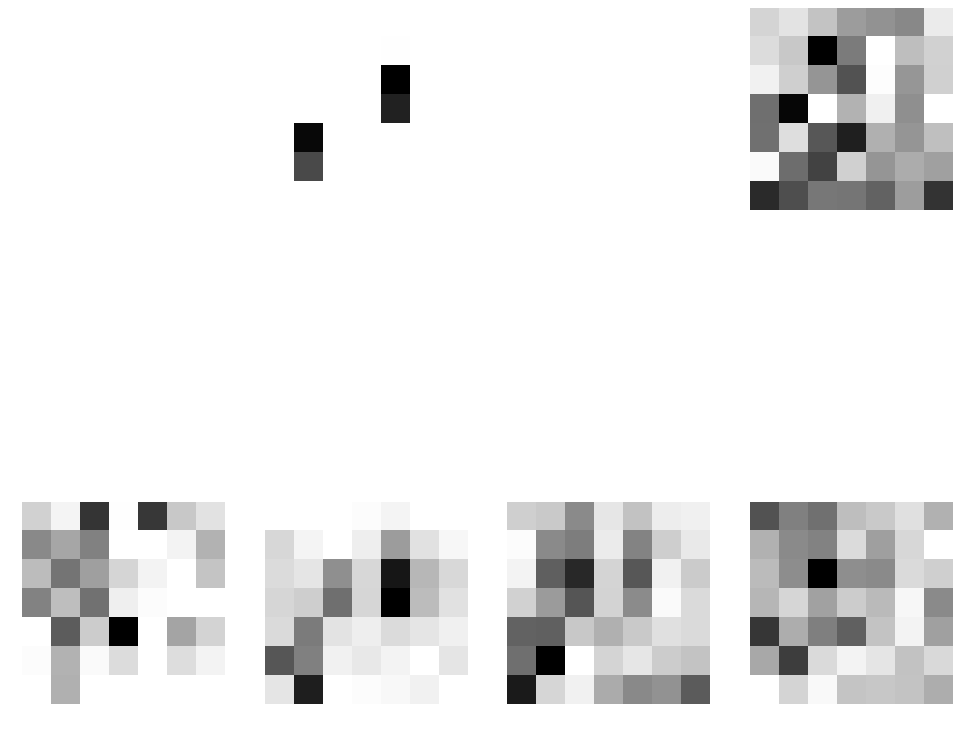

In [35]:

new_model = Model(inputs=input_im, 
                  outputs=model.get_layer('conv2d_12').output)
con2_activations = new_model.predict(x_test[0,:,:].reshape((1,32,32,3)))
print('Convolution 2 shape:',con2_activations.shape)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,15), dpi=80)

for i,ax in enumerate(axes.flatten()):
    ax.imshow(con2_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

###### Plot loss and accuracy

We plot the loss and accracy for best model selected, and the three model trained afterewards and select the best learning rate for this problem.

It can be seen from the performance curves that the best performing model is the one with "Batch
Normalization" layer. <br>
We will use this model to observe the effects of the changing the learning rate.
Since the default learning rate is 0.001, we use two learning rates here: <br>
-Very high compared to default learning rate: 5.0 <br>
-Very low compared to default learning rate: 0.00001

In [37]:
#starting with lr = 5.0

model = None


model_name = '17060015_model61'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
# ====================================================   
input_im = Input(shape=(input_shape), name='input_im')
# Hidden Layers
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
norm1 = BatchNormalization()(conv2) # batch normalization
flat = Flatten()(norm1)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)
model = Model(inputs=input_im, outputs=output_class)
# ====================================================
#for the learning rate : 5.0
adam = Adam(lr=5)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

#save model


epochs = 20
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = 'mean_shift')
val_gen = data_generator(x_val, y_val, batch_size)
test_gen = data_generator(x_test, y_test, batch_size)


hist61 = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)# add your code here

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 16)          1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 44)                34540     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                450       
Total para

In [38]:
#Here we test lr = 0.00001

model = None


model_name = '17060015_model62'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
# ====================================================   
input_im = Input(shape=(input_shape), name='input_im')
# Hidden Layers
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
norm1 = BatchNormalization()(conv2)
flat = Flatten()(norm1)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)
model = Model(inputs=input_im, outputs=output_class)
# ====================================================

adam = Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

epochs = 20
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = 'mean_shift')
val_gen = data_generator(x_val, y_val, batch_size)
test_gen = data_generator(x_test, y_test, batch_size)

hist62 = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 16)          1168      
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 44)                34540     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                450       
Total para

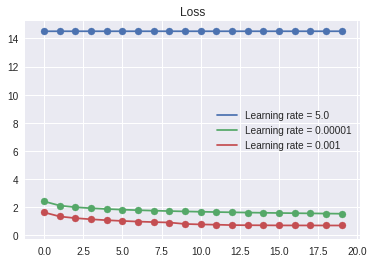

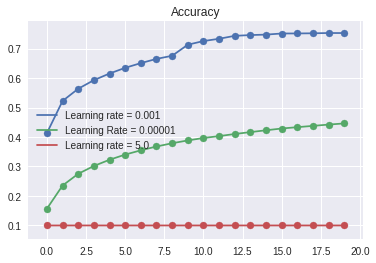

In [39]:
# plot loss of all models
plt.clf() 
x_axis = list(range(epochs))
plt.plot(x_axis, hist61.history['loss'], label='Learning rate = 5.0')
plt.scatter(x_axis, hist61.history['loss'])
plt.plot(x_axis, hist62.history['loss'], label='Learning rate = 0.00001')
plt.scatter(x_axis, hist62.history['loss'])
plt.plot(x_axis, hist41.history['loss'], label='Learning rate = 0.001')
plt.scatter(x_axis, hist41.history['loss']) #default learning rate
plt.legend()
plt.title('Loss')
plt.show()


# plot Accuracy of all models
plt.clf() 
x_axis = list(range(epochs))
plt.plot(x_axis, hist41.history['acc'], label='Learning rate = 0.001')
plt.scatter(x_axis, hist41.history['acc']) #best model with default learning rate
plt.plot(x_axis, hist62.history['acc'], label='Learning Rate = 0.00001')
plt.scatter(x_axis, hist62.history['acc'])
plt.plot(x_axis, hist61.history['acc'], label='Learning rate = 5.0')
plt.scatter(x_axis, hist61.history['acc'])
plt.legend()
plt.title('Accuracy')
plt.show()

###### Observation:
Clearly, the default learning rate has significant performance gain over the two custom learning rates.